In [37]:
import pickle
import numpy as np
import scipy
import os
import matplotlib.pyplot as plt
from neural_tuning import generate_tuning_curves, create_spikes_array, plot_raster
seed = 10050

In [38]:
base_dir = os.path.expanduser('~') + '/leapTracker/datafiles/letters/characterBlocks'
datafile = os.path.join(base_dir, 'block1_2022-10-19.csv')
timingfile = os.path.join(base_dir, 'block1_2022-10-19.pkl')
# timing = pickle.load(open(timingfile, 'rb'))
# datafile = os.path.join(base_dir, 'block2_2022-10-19.pkl')
data = pickle.load(open(timingfile, 'rb'))

In [39]:
tuning_data = scipy.io.loadmat('../datafiles/tuning.mat')
tuning_data = np.array(tuning_data['tuningMat'])
n_units = 192
tuning_curves = generate_tuning_curves(tuning_data, n_units, seed)

In [36]:
data_array = np.genfromtxt(datafile, delimiter=',', skip_header = 2,
                  usecols=(0,1,2,3,4), skip_footer=1)
print(data_array.shape)
# data_array = data['motionData']
fs = 1 / np.mean(data_array[:,0])
print(fs)
print(data_array.shape)

106.76667792569816
(55, 5)


In [25]:
num_forward = np.rint(2 * fs).astype(int)
num_back = np.rint(0.5 * fs).astype(int)
print('Forward: {}; Back: {}'.format(num_forward, num_back))

Forward: 214; Back: 53


In [26]:
print(data.keys())

dict_keys(['timelist', 'charPrompts', 'motionData'])


In [27]:
timelist = data['timelist'][1:]
cue_idx = np.rint(timelist * fs).astype(int)
print(cue_idx)
print(len(cue_idx))

[  286  1148  2022  3030  3968  4852  5816  6775  7714  8652  9592 10508
 11390 12348 13225 14167 15091 16031 16902 17792 18642 19538 20465 21393
 22294 23135 24006 24919 25754 26625 27448]
31


In [28]:
data_array = data_array[~np.isnan(data_array).any(axis=1)]
print(data_array.shape)

(55, 5)


In [29]:
print(data_array[cue_idx[0]-num_back:cue_idx[0]+num_forward, :].shape)

(0, 5)


/home/colin-wsl/.pyenv/versions/3.10.7/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/colin-wsl/.pyenv/versions/3.10.7/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


IndexError: index 0 is out of bounds for axis 0 with size 0

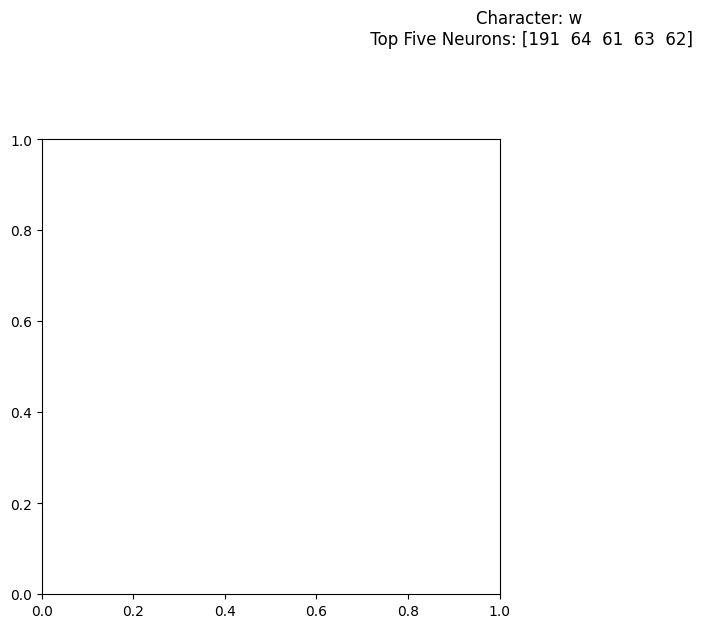

In [30]:
cue = 0.5
for i in range(len(cue_idx)):
    temp_array = data_array[cue_idx[i]-num_back:cue_idx[i]+num_forward, :]
    spikes_array, smoothed_spikes, time, dt, z, x, vz, vx = create_spikes_array(temp_array, tuning_curves, 3, seed)

    mns = np.mean(spikes_array, axis=1)
    mns_data = np.concatenate((smoothed_spikes, mns.reshape(-1,1)), axis=1)
    tops = np.argpartition(mns, -5)
    mns_data_sorted = mns_data[mns_data[:,-1].argsort()]

    char = data['charPrompts'][i]

    fig = plt.figure(figsize=(13,13))
    plt.suptitle('Character: {}\n Top Five Neurons: {}'.format(char, np.flip(tops[-5:])))

    ax1 = fig.add_subplot(221)
    ax1.plot(x[0], -z[0], marker='o', color='red')
    ax1.plot(x[-1], -z[-1], marker='o', color='blue')
    ax1.quiver(x, -z, vx, -vz)
    ax1.set_xlabel('X (mm)', fontweight='bold')
    ax1.set_ylabel('Z (mm)', fontweight='bold')
    ax1.set_title('Vector Field')

    ax2 = fig.add_subplot(222)
    plot_raster(time, cue, spikes_array, char)

    ax3 = fig.add_subplot(223)
    ax3.imshow(smoothed_spikes)
    ax3.set_title('Smoothed Spike Data')
    ax3.set_xticks([])
    ax3.set_yticks([])

    ax4 = fig.add_subplot(224)
    ax4.imshow(mns_data_sorted)
    ax4.set_title('Sorted Smoothed Spike Data')
    ax4.set_xticks([])
    ax4.set_yticks([])
    plt.show()